# Tutorial11: PLLaVA视频理解模型推理

建议在SCOW AI集群运行本教程。推荐使用[PLLaVA-NPU库](https://github.com/SunnyMass/PLLaVA-NPU)的代码。

本节旨在使用 [pllava-7b](https://huggingface.co/ermu2001/pllava-7b) 模型展示多模态视频理解模型的推理。

分以下几步来实现：
1. 环境安装
2. 下载模型
3. 3D池化算子适配
4. 模型推理

## 1. 环境安装

登录scow平台申请资源。选择公共基础镜像，并申请资源，建议使用1张910B NPU运行本教程。

连接作业，到vscode远程平台。

下载PLLaVA-NPU项目

In [ ]:
git clone https://github.com/SunnyMass/PLLaVA-NPU.git
cd PLLaVA-NPU

按照如下方式创建conda虚拟环境，并安装所需库。

In [ ]:
conda create -n pllava python=3.10
conda activate pllava
pip install -r requirement.txt
apt-get install -y libgl1 libglib2.0-0 libgl1-mesa-glx

## 2. 下载模型

按照如下方式下载pllava-7b模型。

```bash
export HF_ENDPOINT=https://hf-mirror.com
huggingface-cli download --resume-download ermu2001/pllava-7b --local-dir pllava-7b
```
模型本地地址为：./pllava-7b

## 3. 3D池化算子适配

由于 NPU 不支持包括 AdaptiveAvgPool3d 在内的多种 3D 池化算子，因此我们手动实现一个兼容 NPU 的 3D 池化函数，用于在不改变数值语义的前提下，完成时间维度和空间维度的降采样，确保推理过程与 GPU 上一致，避免出现映射错乱或语义幻觉等问题。该函数完全复现了 AdaptiveAvgPool3d 的行为，前提是输入的时间、空间尺寸能整除目标尺寸。适用于大多数实际配置，同时在 NPU 上高效可用，确保视觉特征 token 数在时空维度的稀疏化过程保持一致。

修改方式：
在**PLLaVA/models/pllava/modeling_pllava.py**文件中修改，修改class PllavaMultiModalProjector(nn.Module):中的forward函数
把self.pooling替换为自定义实现。(目前代码中已完成修改，用户可以直接拉取，无需修改)（该实现已经验证在GPU和NPU的输出保持一致。）



## 4. 模型推理

PLLaVA-7B 是一个面向视频理解任务的开源多模态聊天模型。该模型在图像大模型的基础上，进一步引入视频指令数据进行微调，具备视频内容理解与问答能力。其底层语言模型为 llava-hf/llava-v1.6-vicuna-7b-hf，采用 Transformer 架构，具备自回归生成能力。

推理过程中使用 npu-smi info 命令可以查看 NPU 运行情况。

推荐直接使用[PLLaVA-NPU库](https://github.com/SunnyMass/PLLaVA-NPU)的代码运行。

运行命令：(注意：将path_to_pllava7b替换为模型的本地路径)


In [ ]:

python run_demo.py   \
--video_path ./1-2.mp4  \
--prompt "describe this video in detail" \
--pretrained_model_name_or_path path_to_pllava7b  \
--weight_dir path_to_pllava7b   \
--use_lora  \
--num_frames 16  \
--conv_mode plain \
--max_new_tokens 128 \
 --video_caption(如果是做视频caption任务就加上，如果是其他视频理解任务就不加)

如果希望模型可以交互演示，可以采用gradio。用户修改scripts/demo.sh中的model_dir和weight_dir, 再运行demo.sh，部署gradio

In [ ]:
sh ./scripts/demo.sh

如果用户希望修改url地址，用户可以在PLLaVA/tasks/eval/demo/pllava_demo.py文件末尾定义url地址，具体修改内容如下。

In [ ]:
demo.launch(
    server_name="0.0.0.0",
    server_port=10034,
    root_path="/ai/api/proxy/ascend-k8s/relative/master/30003/proxy/10034"
)

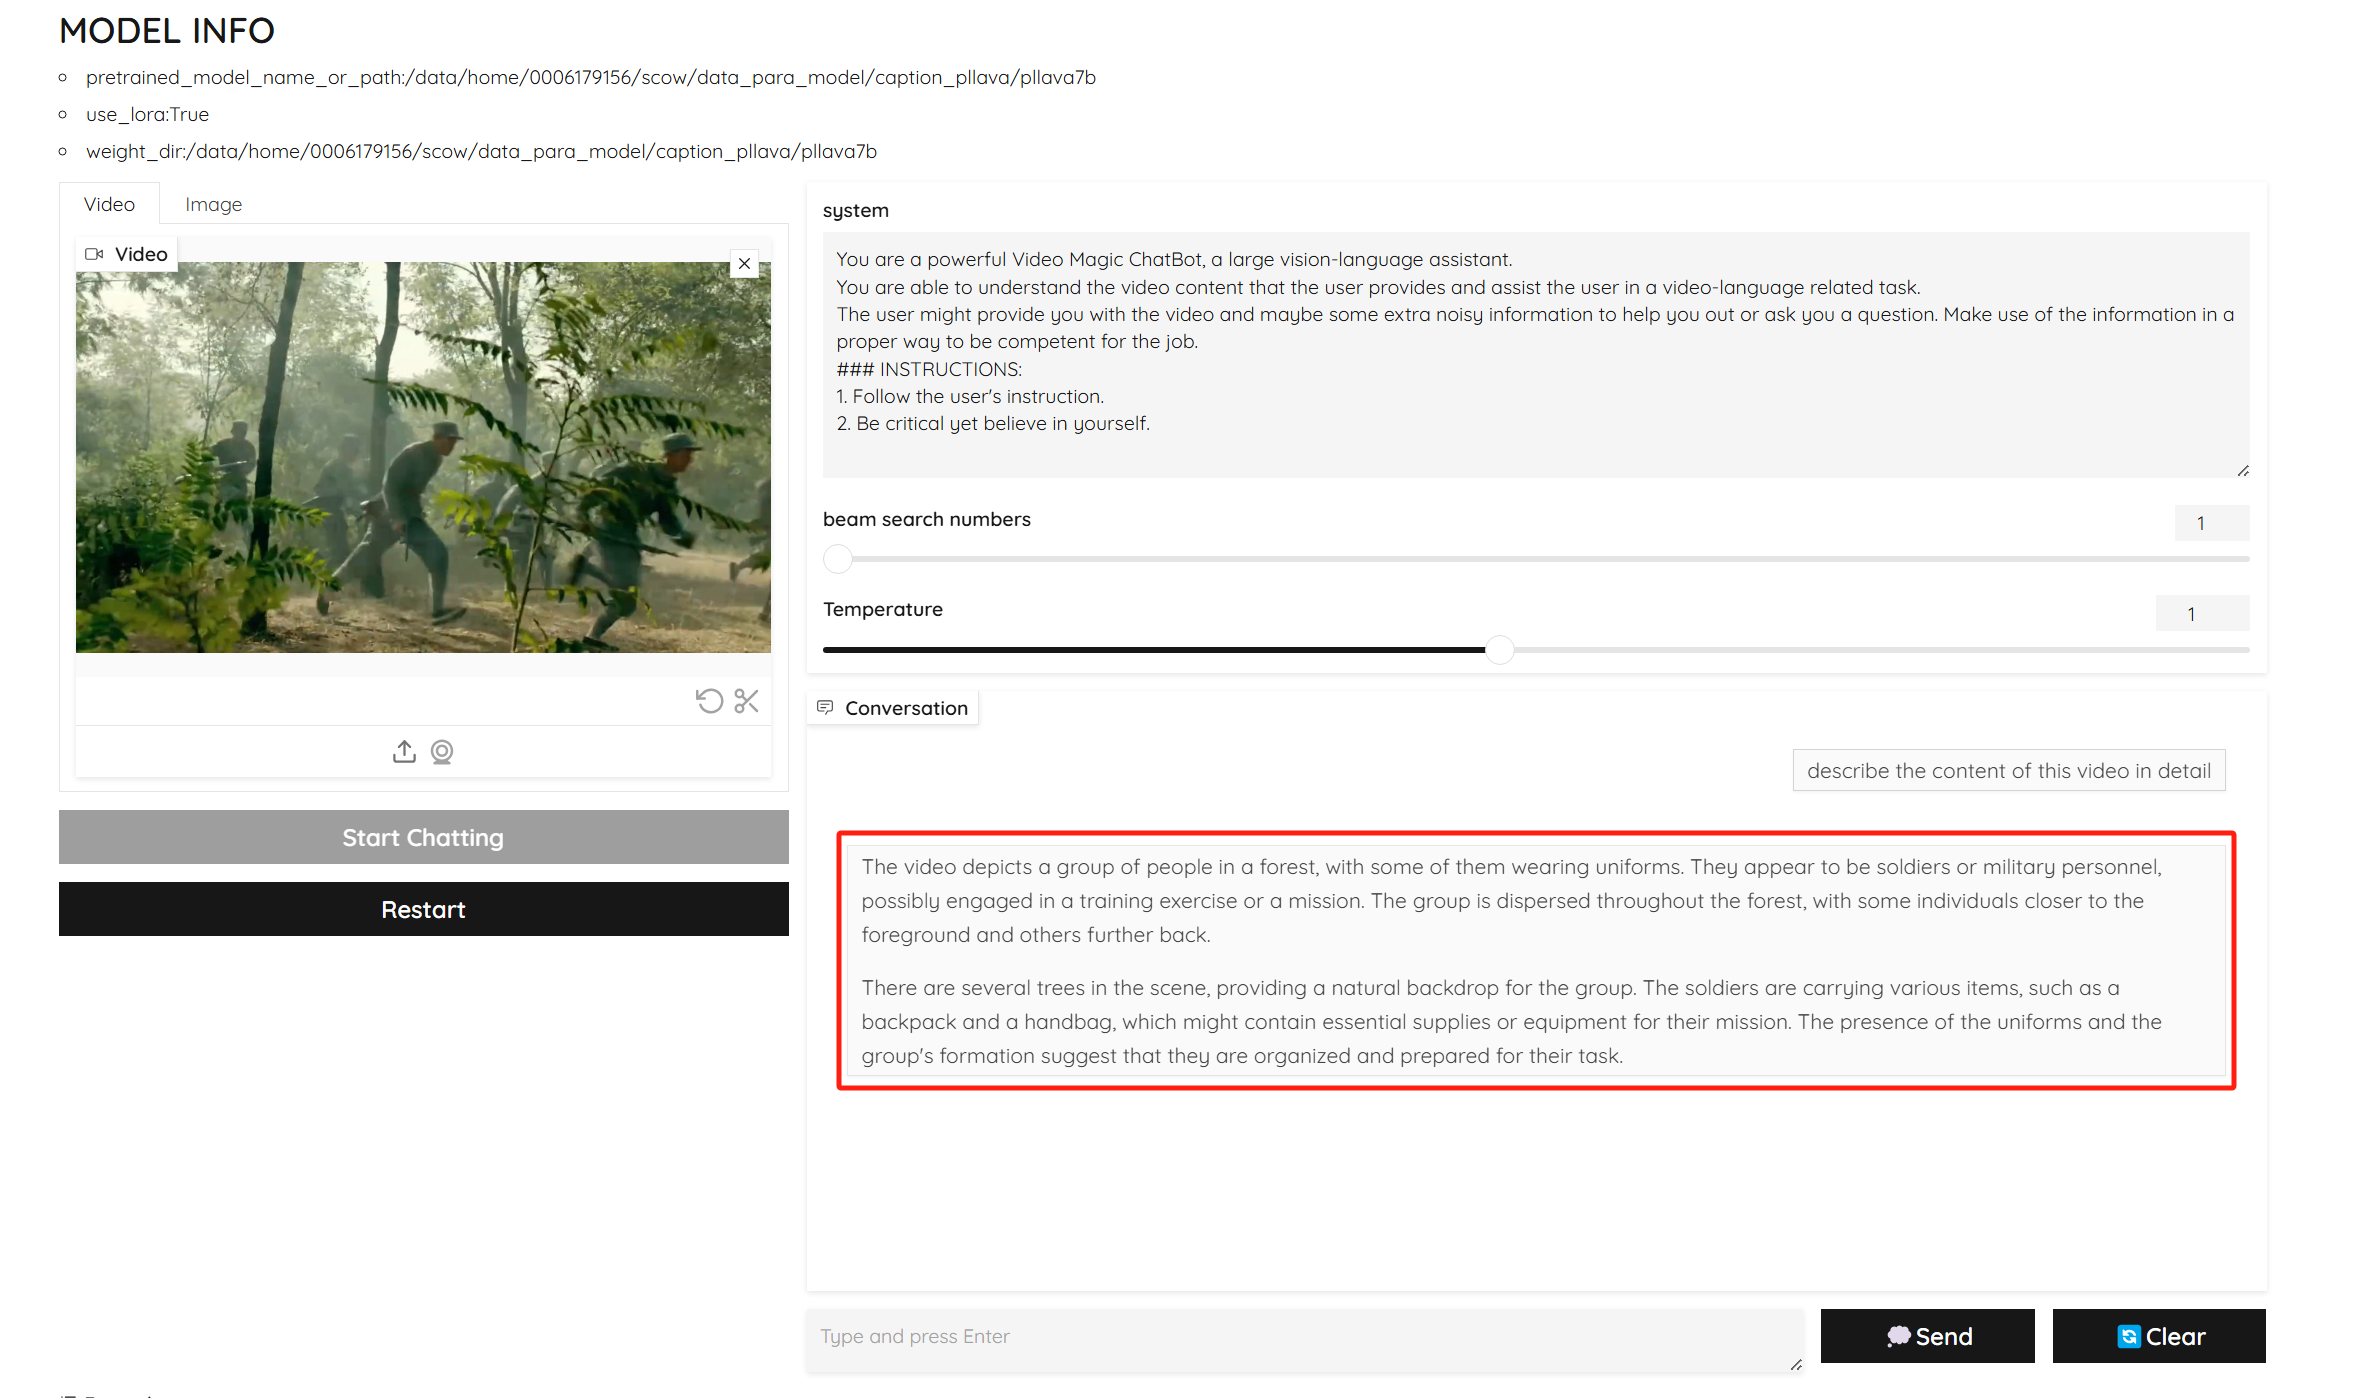

---

> 作者: 张天戈; 林荣群; 石晶; 贾川民; 马思伟
>
> 联系方式: tgzhang@stu.pku.edu.cn